In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random

In [2]:
# Functions to read and write xyz 

def read_xyz(filename):
    """Read XYZ file and return atom names and coordinates

    Args:
        filename:  Name of xyz data file

    Returns:
        atom_names: Element symbols of all the atoms
        coords: Cartesian coordinates for every frame.
    """
    coors = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                natm = int(line)  # Read number of atoms
                next(f)     # Skip over comments
                atom_names = []
                xyz = []
                for i in range(natm):
                    line = next(f).split()
                    atom_names.append(line[0])
                    xyz.append(
                        [float(line[1]), float(line[2]), float(line[3])])
                coors.append(xyz)
            except (TypeError, IOError, IndexError, StopIteration):
                raise ValueError('Incorrect XYZ file format')

    return atom_names, coors


def write_xyz(filename, atoms, coords): 
    """Write atom names and coordinate data to XYZ file

    Args:
        filename:   Name of xyz data file
        atoms:      Iterable of atom names
        coords:     Coordinates, must be of shape nimages*natoms*3
    """ 
    natoms = len(atoms)
    with open(filename, 'w') as f:
        for i, X in enumerate(np.atleast_3d(coords)):
            f.write("%d\n" % natoms)
            f.write("Frame %d\n" % i)
            for a, Xa in zip(atoms, X): 
                f.write(" {:3} {:21.12f} {:21.12f} {:21.12f}\n".format(a, *Xa)) 


In [10]:
# Read data

folder = './'
filename = folder+'/model_devi.out'     # name of model deviation file 

filename_colvar = folder+'/COLVAR'

data = np.loadtxt(filename)
colvar = np.loadtxt(filename_colvar)
print('Number of DATA point', len(data),len(colvar))
print('Simulation Time',(len(data)*0.00025)*20)

Number of DATA point 6627 6627
Simulation Time 33.135


In [11]:
# Read traj 

file_xyz = folder+'dump.0.xyz'         # name of xyz file 
print('Reading ',file_xyz)
atoms, coords = read_xyz(file_xyz)
print('End reading ',file_xyz)

Reading  ./dump.0.xyz
End reading  ./dump.0.xyz


Average (eV/A):  0.13462660914290026
Max (eV/A):  1.993732
Min (eV/A):  0.04156596
Max dist (eV/A):  0.0610876204


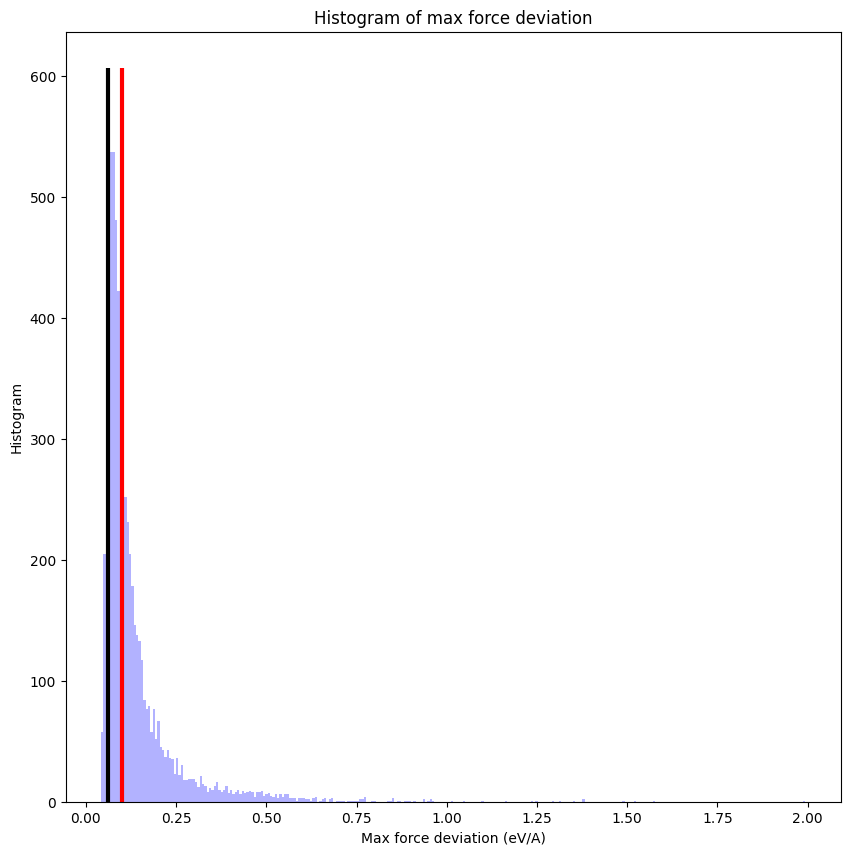

In [12]:
# Histrogram of Maximum Force Deviation   

MF = data[:,4]
max_MF = np.amax(MF)
min_MF = np.amin(MF)
av_MF = np.average(MF)


print('Average (eV/A): ', av_MF)
print('Max (eV/A): ', max_MF)
print('Min (eV/A): ', min_MF)

nbin = 300 

hist = plt.hist(MF, bins = nbin, color = 'blue', alpha=0.3)

# compute max sigma distribution
sigma_max = hist[1][np.argmax(hist[0])]
print('Max dist (eV/A): ', sigma_max)

plt.vlines(sigma_max, 0, (np.amax(hist[0])+(np.amax(hist[0])*0.1)), color = 'black', linewidth=3)
plt.vlines(0.1, 0, (np.amax(hist[0])+(np.amax(hist[0])*0.1)), color = 'red', linewidth=3)
plt.title('Histogram of max force deviation')
plt.xlabel('Max force deviation (eV/A)')
plt.ylabel('Histogram')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [13]:
time = colvar[:,0]
bn = colvar[:,1]
bh = colvar[:,2]

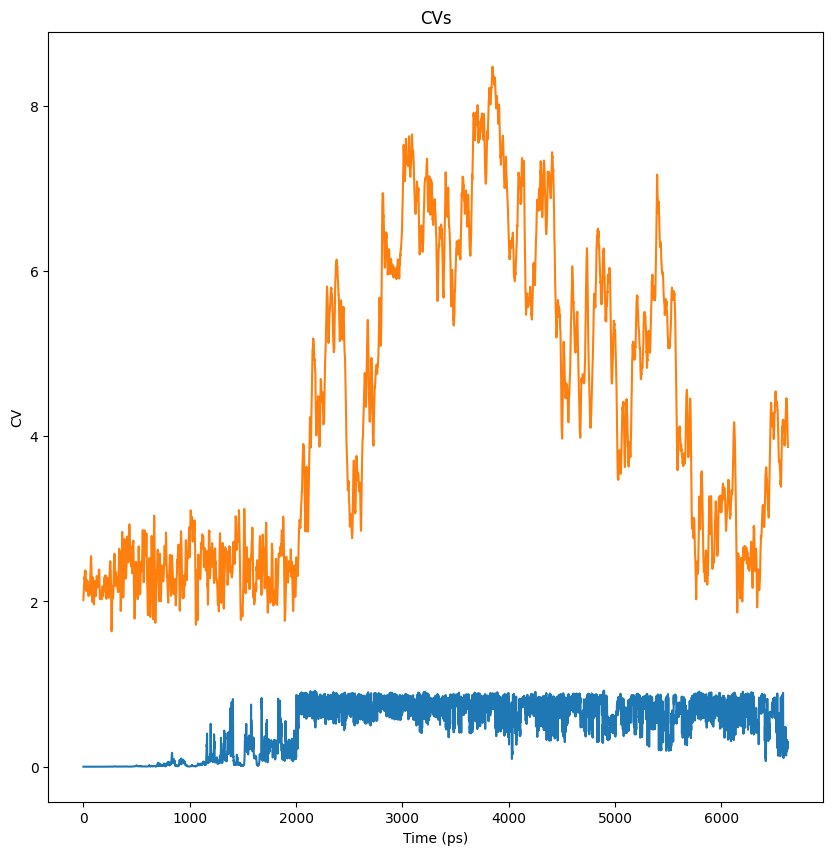

In [14]:
plt.plot(time,bn)
plt.plot(time,bh)
plt.title('CVs')
plt.xlabel('Time (ps)')
plt.ylabel('CV')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()


In [15]:
# Set intervals  

#Intervals 
interval_1 = [0.05, 0.10]
interval_2 = [0.1, 0.2]
interval_3 = [0.2, 0.30]

thr1_bh = 3.0
thr2_bh = 4.5
thr1_bn = 0.4
thr2_bn = 1.0


#-------------------------------------------------------------------------------

int1_geom = []
int2_geom = []
int3_geom = []

int1_Ntot = 0
int2_Ntot = 0
int3_Ntot = 0

for i in range(len(MF)):
    if MF[i] >= interval_1[0] and MF[i] < interval_1[1] and bn[i] < thr2_bn and bn[i] > thr1_bn and (bh[i] < thr2_bh and bh[i] > thr1_bh):
#    if bh[i] < thr2_bh and bh[i] > thr1_bh and (bn[i] < thr2_bn and bn[i] > thr1_bn):
        int1_Ntot += 1
        int1_geom.append(i)
    elif MF[i] >= interval_2[0] and MF[i] < interval_2[1] and bn[i] < thr2_bn and bn[i] > thr1_bn and bh[i] < thr2_bh and bh[i] > thr1_bh:
        int2_Ntot += 1
        int2_geom.append(i)
    elif MF[i] >= interval_3[0] and MF[i] < interval_3[1] and bn[i] < thr2_bn and bn[i] > thr1_bn and bh[i] < thr2_bh and bh[i] > thr1_bh:
        int3_Ntot += 1
        int3_geom.append(i)

print('Configurations interval [{},{}]: {};{} %'.format(interval_1[0],interval_1[1],int1_Ntot,int1_Ntot/len(MF)))
print('Configurations interval [{},{}]: {};{} %'.format(interval_2[0],interval_2[1],int2_Ntot,int2_Ntot/len(MF)))
print('Configurations interval [{},{}]: {};{} %'.format(interval_3[0],interval_3[1],int3_Ntot,int3_Ntot/len(MF)))

#-------------------------------------------------------------------------------

Configurations interval [0.05,0.1]: 589;0.08887882903274483 %
Configurations interval [0.1,0.2]: 330;0.04979628791308284 %
Configurations interval [0.2,0.3]: 64;0.009657461898294854 %


In [16]:
# Random selection of configuration

# Nsample in each bin 
Nsample_int1 = 70
Nsample_int2 = 50
Nsample_int3 = 20

file_geom1 = folder+'geom_int1.xyz'
file_geom2 = folder+'geom_int2.xyz'
file_geom3 = folder+'geom_int3.xyz'

filename_output = folder+'output_selected.log'     # name of model deviation file 
#-------------------------------------------------------------------------------

selected_geom_int1 = sorted(random.sample(int1_geom, Nsample_int1))
selected_geom_int2 = sorted(random.sample(int2_geom, Nsample_int2))
selected_geom_int3 = sorted(random.sample(int3_geom, Nsample_int3))

#write output 
print('Writing output resume')
with open(filename_output, 'w') as f:
    f.write("#Selected Frame 1 interval:\n")
    f.write("#--------------------------\n")
    for i in range(len(selected_geom_int1)):
        f.write("{} {} {} {} {} {} {} {}\n".format(selected_geom_int1[i], *data[selected_geom_int1[i]]))
    f.write("#--------------------------\n")
    f.write("#Selected Frame 2 interval:\n")
    f.write("#--------------------------\n")
    for i in range(len(selected_geom_int2)):
        f.write("{} {} {} {} {} {} {} {}\n".format(selected_geom_int2[i], *data[selected_geom_int2[i]]))
    f.write("#--------------------------\n")
    f.write("#Selected Frame 3 interval:\n")
    f.write("#--------------------------\n")
    for i in range(len(selected_geom_int3)):
        f.write("{} {} {} {} {} {} {} {}\n".format(selected_geom_int3[i], *data[selected_geom_int3[i]]))

#write configurations
selected_coords_int1 = [coords[i] for i in selected_geom_int1]
selected_coords_int2 = [coords[i] for i in selected_geom_int2]
selected_coords_int3 = [coords[i] for i in selected_geom_int3]

print('Writing ',file_geom1)
write_xyz(file_geom1, atoms, selected_coords_int1)
print('Writing ',file_geom2)
write_xyz(file_geom2, atoms, selected_coords_int2)
print('Writing ',file_geom3)
write_xyz(file_geom3, atoms, selected_coords_int3)



Writing output resume
Writing  ./geom_int1.xyz
Writing  ./geom_int2.xyz
Writing  ./geom_int3.xyz
